In [67]:
%matplotlib inline
import numpy as np
from astropy.io import ascii, fits
import matplotlib.pyplot as plt
from photutils import aperture_photometry as ap
from photutils import CircularAperture, CircularAnnulus
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import wcs
from hyperion.model import ModelOutput
import astropy.constants as const

pc = const.pc.cgs.value
AU = const.au.cgs.value

## Calculate the radial intensity profile by taking the difference between apertues

In [93]:
# Read in data and set up coversions
im_hdu = fits.open('/Users/yaolun/bhr71/data/photometry/herschel_photometry/'+
               '1342226633/level2/extdPMW/hspirepmw1342226633_20pxmp_1431669350070.fits')
im = im_hdu[1].data
w = wcs.WCS(im_hdu[1].header)

coord = SkyCoord('12 01 36.3 -65 08 53.0', unit=(u.hourangle, u.deg))
pixcoord = w.wcs_world2pix(coord.ra.degree, coord.dec.degree, 1)
pix2arcsec = abs(im_hdu[1].header['CDELT1'])*3600.
# convert intensity unit from MJy/sr to Jy/pixel
factor = 1e6/4.25e10*abs(im_hdu[1].header['CDELT1']*im_hdu[1].header['CDELT2'])*3600**2

# radial grid in arcsec
annulus_width = 10
r = np.arange(10, 200, annulus_width, dtype=float)
I = np.empty_like(r[:-1])

# iteration
for ir in range(len(r)-1):
    aperture = CircularAnnulus((pixcoord[0],pixcoord[1]), r_in=r[ir]/pix2arcsec, r_out=r[ir+1]/pix2arcsec)
#     print aperture.r_in
    phot = ap(im, aperture)
    I[ir] = phot['aperture_sum'].data * factor / aperture.area()
    print r[ir], I[ir]

10.0 4.45800914796
20.0 2.36702011777
30.0 1.083804783
40.0 0.647448026682
50.0 0.47568876684
60.0 0.385635745263
70.0 0.339015508109
80.0 0.308392777611
90.0 0.284202992123
100.0 0.262175891828
110.0 0.243428433608
120.0 0.228935603329
130.0 0.219104291839
140.0 0.211620014312
150.0 0.204559853469
160.0 0.197207059431
170.0 0.190255806671
180.0 0.184039527126


In [94]:
print I/I.max()

[ 1.          0.53095901  0.24311408  0.14523255  0.1067043   0.08650403
  0.07604639  0.06917724  0.0637511   0.05881008  0.05460474  0.05135378
  0.04914846  0.04746962  0.04588592  0.04423658  0.0426773   0.0412829 ]


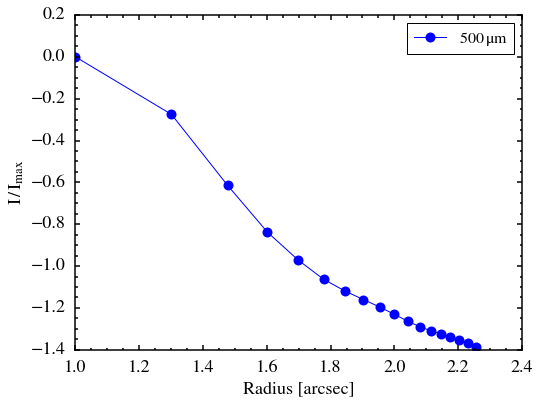

In [96]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

i, = ax.plot(np.log10(r[:-1]), np.log10(I/I.max()), 'o-', mec='None', markersize=10)

ax.legend([i], [r'$\rm{500\,\mu m}$'], fontsize=16, numpoints=1, loc='upper right')
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
ax.set_xlabel('Radius [arcsec]', fontsize=18)
ax.set_ylabel(r'$\rm{I\,/\,I_{max}}$', fontsize=18)

## Do the same thing for simulations

In [97]:
# read in from RTout
rtout = ModelOutput('/Users/yaolun/bhr71/hyperion/model9.rtout')
# setting up parameters
dstar = 200.
group = 8
wave = 500.0

im = rtout.get_image(group=group, inclination=0, distance=dstar*pc, units='Jy')

# Find the closest wavelength
iwav = np.argmin(np.abs(wave - im.wav))
# avoid zero when log, and flip the image
val = im.val[::-1, :, iwav]

w = np.degrees(max(rtout.get_quantities().r_wall) / im.distance) * 3600
npix = len(val[:,0])
pix2arcsec = 2*w/npix

In [98]:
# radial grid in arcsec
annulus_width = 10
r = np.arange(10, 200, annulus_width, dtype=float)
I_sim = np.empty_like(r[:-1])

# iteration
for ir in range(len(r)-1):
    aperture = CircularAnnulus((npix/2.+0.5, npix/2.+0.5), r_in=r[ir]/pix2arcsec, r_out=r[ir+1]/pix2arcsec)
#     print aperture.r_in
    phot = ap(val, aperture)
    I_sim[ir] = phot['aperture_sum'].data / aperture.area()
    print r[ir], I_sim[ir]

10.0 0.0281436143124
20.0 0.0104700841846
30.0 0.00529501227527
40.0 0.00312053421118
50.0 0.00202953414461
60.0 0.0013743020377
70.0 0.000993473349476
80.0 0.000730044350939
90.0 0.000544757839826
100.0 0.000422078056381
110.0 0.000327208990358
120.0 0.000253674173475
130.0 0.00019753487939
140.0 0.000156650714813
150.0 0.000122280136117
160.0 9.30661722117e-05
170.0 6.86836165923e-05
180.0 4.59905615077e-05


In [99]:
print np.log10(I_sim/I_sim.max())
print np.log10(I/I.max())
print np.log10(r[:-1])

[ 0.         -0.4294297  -0.7255129  -0.95515092 -1.14198351 -1.31129768
 -1.45222365 -1.58603063 -1.71317638 -1.8239871  -1.93455464 -2.04510362
 -2.15373608 -2.25444749 -2.36202396 -2.48058802 -2.61252672 -2.78671116]
[ 0.         -0.27493901 -0.61418989 -0.83793604 -0.97181806 -1.06296367
 -1.11892139 -1.16003676 -1.19551231 -1.2305482  -1.26276965 -1.28942762
 -1.30849007 -1.32358422 -1.33832055 -1.3542185  -1.36980303 -1.38422985]
[ 1.          1.30103     1.47712125  1.60205999  1.69897     1.77815125
  1.84509804  1.90308999  1.95424251  2.          2.04139269  2.07918125
  2.11394335  2.14612804  2.17609126  2.20411998  2.23044892  2.25527251]


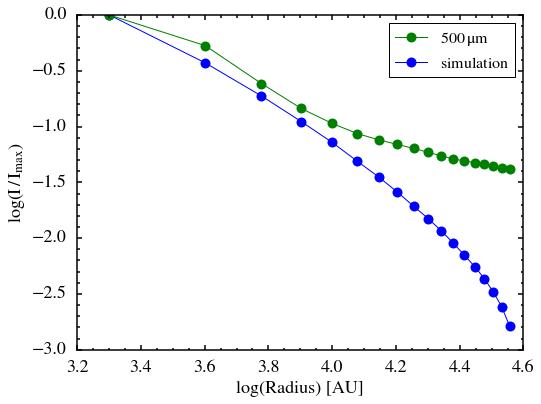

In [102]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

i_sim, = ax.plot(np.log10(r[:-1]*dstar), np.log10(I_sim/I_sim.max()), 'o-', mec='None', markersize=10)
i, = ax.plot(np.log10(r[:-1]*dstar), np.log10(I/I.max()), 'o-', mec='None', markersize=10)

ax.legend([i, i_sim], [r'$\rm{500\,\mu m}$', r'$\rm{simulation}$'], fontsize=16, numpoints=1, loc='upper right')
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
ax.set_xlabel('log(Radius) [AU]', fontsize=18)
ax.set_ylabel(r'$\rm{log(I\,/\,I_{max})}$', fontsize=18)